In [67]:
# Cargar los datos de entrenamiento
import numpy as np
train_matrix = np.load('../features/matriz_datos_train.npy')

# Seleccionar las features y target
X_train = train_matrix[:,:-1]
y_train = train_matrix[:, -1]

print(np.shape(X_train))

(152, 23)


In [68]:
# Estandarización de los datos de entrenamiento
from sklearn.preprocessing import StandardScaler
estandarizador = StandardScaler()
estandarizador.fit(X_train)
mu = estandarizador.mean_
sigma = np.sqrt(estandarizador.var_)
X_train = estandarizador.transform(X_train)

# print(X_train[0])
# print(X_train_new[0])

In [69]:
# SELECCIÓN DE LOS ATRIBUTOS (CARACTERÍSTICAS)
# Estudiar si las variables siguen una distribución normal de media 0 y desviación típica 1 --> N(0,1)
from scipy.stats import kstest # Prueba de Kolmogorov-Smirnov

alpha = 0.01 # nivel de confianza del 99%
h_norm = np.zeros(X_train.shape[1])
for i in range(0, X_train.shape[1]):
    _, pvalue = kstest(X_train[:, i], 'norm')
    
    # Contraste de hipótesis
    if pvalue<=alpha:
        h_norm[i] = 0 # Los datos NO siguen una distribución normal N(0,1)
    else:
        h_norm[i] = 1 # Los datos SÍ siguen una distribución normal N(0,1)

print('0: no normal  ---- 1: sí normal: ', h_norm)

0: no normal  ---- 1: sí normal:  [1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [70]:
def draw_boxplot(data1, data2, ticks):
    import matplotlib.pyplot as plt
    
    bpl = plt.boxplot(data1, positions=np.array(range(np.shape(data1)[1]))*2.0-0.4, sym='', widths=0.5, \
                     boxprops=dict(color='red'),
                     capprops=dict(color='red'),
                     whiskerprops=dict(color='red'),
                     medianprops=dict(color='red'))
    
    bpl = plt.boxplot(data2, positions=np.array(range(np.shape(data2)[1]))*2.0+0.4, sym='', widths=0.5, \
                     boxprops=dict(color='blue'),
                     capprops=dict(color='blue'),
                     whiskerprops=dict(color='blue'),
                     medianprops=dict(color='blue'))
    
    plt.plot([], c='#D7191C', label='Glaucoma')
    plt.plot([], c='#2C7BB6', label='Healthy')
    plt.legend()
    
    plt.xticks(range(0, len(ticks)*2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.grid(True)
    plt.title('Características')
    plt.show()
    

0: no discrimna, 1: sí discrimina [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
(152, 18)
(18,)
(18,)


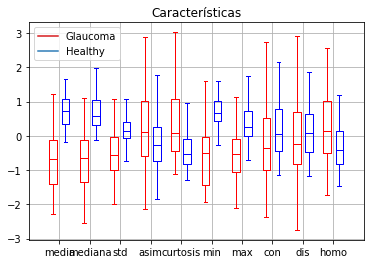

Características discriminatorias:  ['media' 'mediana' 'std' 'asim' 'curtosis' 'min' 'max' 'homo' 'ASM' 'E'
 'LBP1' 'LBP3' 'LBP4' 'LBP5' 'LBP6' 'LBP7' 'LBP8' 'LBP9']
Características NO discriminatorias:  ['COR' 'LBP10' 'LBP2' 'con' 'dis']


In [72]:
# Estudiar la capacidad discriminativa de los atributos en función de su distribución
from scipy.stats import ttest_ind, mannwhitneyu

glaucoma_data = X_train[y_train==1]
healthy_data = X_train[y_train==0]

h = np.zeros(X_train.shape[1])
h_disc = np.zeros(X_train.shape[1])

for i in range(0, X_train.shape[1]):
    if h_norm[i] == 0: # no es normal --> comparación de medianas (mannwhitneyu)
        _, pvalue = mannwhitneyu(glaucoma_data[:,i], healthy_data[:,i])
    else: # sí es normal --> comparación de medias (ttest_ind)
        _, pvalue = ttest_ind(glaucoma_data[:,i], healthy_data[:,i])
    
    # contraste de hipótesis, estudiar el poder discriminatorio de las características
    # H0: independencia entre la característica y la clase
    if pvalue<=alpha:
        h_disc[i] = 1 # Se rechaza la H0 y, por tanto, asumimos la dependencia entre la característica y la clase
    else:
        h_disc[i] = 0 # No hay evidencia para rechazar la H0 y, por tanto, asumimos que la caract. y la clase son independientes

print('0: no discrimna, 1: sí discrimina', h_disc)

# Eliminando las variables que no son discriminatorias. 
id_no_disc = np.where(h_disc==0)
X_train_disc = np.delete(X_train, id_no_disc[0], axis=1)
mu_disc = np.delete(mu, id_no_disc[0])
sigma_disc = np.delete(sigma, id_no_disc[0])

print(np.shape(X_train_disc))
print(np.shape(mu_disc))
print(np.shape(sigma_disc))

# Visualización
original_ticks = ['media', 'mediana', 'std', 'asim', 'curtosis', 'min', 'max', 'con', 'dis', 'homo', 'ASM', 'E', 'COR', 
         'LBP1', 'LBP2', 'LBP3', 'LBP4', 'LBP5', 'LBP6', 'LBP7', 'LBP8', 'LBP9', 'LBP10']
draw_boxplot(glaucoma_data[:,:10], healthy_data[:,:10], original_ticks[:10])

ticks = np.delete(original_ticks, id_no_disc[0])
print('Características discriminatorias: ', ticks)
print('Características NO discriminatorias: ', np.setdiff1d(original_ticks, ticks))

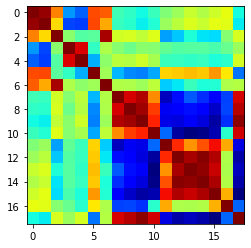

[ 1  6  9 12 13 14 15 17]
Características correladas:  ['mediana' 'max' 'E' 'LBP4' 'LBP5' 'LBP6' 'LBP7' 'LBP9']
Características NO correladas:  ['ASM' 'LBP1' 'LBP3' 'LBP8' 'asim' 'curtosis' 'homo' 'media' 'min' 'std']
(152, 10)


In [73]:
# Realizar un análisis de CORRELACIÓN para ver la dependencia entre pares de variables

R = np.corrcoef(X_train_disc.transpose())

import matplotlib.pyplot as plt
plt.imshow(R, cmap='jet')
plt.show()

th_cor = 0.9

idx = abs(R)>th_cor
mat_tri_sup = np.triu(idx,1)
# print(mat_tri_sup.astype('uint8'))

row, col = np.where(mat_tri_sup==True)
id_corr = np.unique(col)
print(id_corr)

print('Características correladas: ', ticks[id_corr])
print('Características NO correladas: ', np.setdiff1d(ticks, ticks[id_corr]))

# Eliminamos las variables correlacionadas
X_final = np.delete(X_train_disc, id_corr, axis=1)
mu_final = np.delete(mu_disc, id_corr)
sigma_final = np.delete(sigma_disc, id_corr)
ticks = np.delete(ticks, id_corr)

print(np.shape(X_final))

In [80]:
# Guardado de matriz final de características
import os
if not os.path.exists('../final_features'):
    os.mkdir('../final_features')

y_train_exp = np.expand_dims(y_train, axis=1)
train_matrix = np.concatenate((X_final, y_train_exp), axis=1)
np.save('../final_features/train.npy', train_matrix)

In [83]:
# Repetir el proceso para la selección de las características del test

test_matrix = np.load('../features/matriz_datos_test.npy')

# Seleccionar las características y la clase
X_test = test_matrix[:,:-1]
y_test = test_matrix[:, -1]

# Eliminar las características que no son discriminatorias durante entrenamiento
# id_no_disc
X_test_disc = np.delete(X_test, id_no_disc[0], axis=1)

# Eliminar las características correladas durante entrenamiento
# id_corr
X_test_final = np.delete(X_test_disc, id_corr, axis=1)

# Estandarización de las características del test en base a la mu y la sigma del entrenamiento 
X_test_final = (X_test_final-mu_final)/sigma_final

# Guardado de la matriz de datos de test
y_test_exp = np.expand_dims(y_test, axis=1)
test_matrix = np.concatenate((X_test_final, y_test_exp), axis=1)

np.save('../final_features/test.npy', test_matrix)

print(np.shape(X_test_final))

(37, 10)
